# **1. Extracting BERT Embeddings**



## 1.2 Method 2

SUCCESS

from: https://www.kaggle.com/odedgolden/spooky-authors-analysis



In [ ]:
!pip install transformers

  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
# IMPORTS 
from transformers import BertTokenizer, BertModel
import torch 
from sklearn.decomposition import PCA

### **1.2.1 Initiate BERT**

In [ ]:
# data pretrained on: https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt


# to use own pretrained model: 
# Model was saved using `save_pretrained('./test/saved_model/')` (for example purposes, not runnable).
# model = BertModel.from_pretrained('./test/saved_model/')

PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

bert_embeddings = bert_model.get_input_embeddings()

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### **1.2.2 Get the data**

In [ ]:
# mounting google drive
from google.colab import drive

drive.mount('/content/gdrive')

In [ ]:
!cp "/content/gdrive/MyDrive/Colab Notebooks/wino_csv/anti_type1_dev.csv" "/content/anti_type1_dev.csv"
!cp "/content/gdrive/MyDrive/Colab Notebooks/wino_csv/anti_type1_test.csv" "/content/anti_type1_test.csv"

!cp "/content/gdrive/MyDrive/Colab Notebooks/wino_csv/anti_type2_dev.csv" "/content/anti_type2_dev.csv"
!cp "/content/gdrive/MyDrive/Colab Notebooks/wino_csv/anti_type2_test.csv" "/content/anti_type2_test.csv"

!cp "/content/gdrive/MyDrive/Colab Notebooks/wino_csv/pro_type1_dev.csv" "/content/pro_type1_dev.csv"
!cp "/content/gdrive/MyDrive/Colab Notebooks/wino_csv/pro_type1_test.csv" "/content/pro_type1_test.csv"

!cp "/content/gdrive/MyDrive/Colab Notebooks/wino_csv/pro_type2_dev.csv" "/content/pro_type2_dev.csv"
!cp "/content/gdrive/MyDrive/Colab Notebooks/wino_csv/pro_type2_test.csv" "/content/pro_type2_test.csv"

In [ ]:
# read in all dataframes 
import os
import glob
file_extension = '.csv'
all_filenames = [i for i in glob.glob(f"*{file_extension}")]

In [ ]:
all_filenames

['anti_type2_dev.csv',
 'pro_type2_dev.csv',
 'pro_type1_dev.csv',
 'pro_type2_test.csv',
 'pro_type1_test.csv',
 'anti_type2_test.csv',
 'anti_type1_dev.csv',
 'anti_type1_test.csv']

In [ ]:
df = pd.concat([pd.read_csv(f, header=None, names=['text']) for f in all_filenames ])

In [ ]:
df

,text
0,1 The developer argued with [the des...
1,2 The designer argued with [the deve...
2,3 The mechanic gave [the clerk] a pr...
3,4 The clerk gave [the mechanic] a pr...
4,5 The mover said thank you to [the h...
...,...
391,392 The assistant hired [the driver]...
392,393 [The chief] asked the cleaner to...
393,394 The chief asked [the cleaner] to...
394,395 [The teacher] and the janitor we...


remove numbers and square brackets. 

In [ ]:
df['text'] = df['text'].str.replace('\d+', '')

In [ ]:
df['text'] = df['text'].str.replace('\W+', ' ')

In [ ]:
df.to_csv('WinoBias_all_clean.csv')

### **1.2.3 Format the data**

In [ ]:
df['word_ids'] = df['text'].apply(lambda x: tokenizer.convert_tokens_to_ids(tokenizer.tokenize(x)))

In [ ]:
df.head(1)

,text,word_ids
0,The developer argued with the design...,"[1109, 9991, 4491, 1114, 1103, 5592,..."


In [ ]:
def count_words(df):
    cols = ['word']
    word_count = pd.DataFrame(df['text'].str.split(expand=True).stack(), columns = cols)
    return word_count

word_count = count_words(df)
word_count

word
0   0            The
    1      developer
    2         argued
    3           with
    4            the
...              ...
395 7          about
    8            her
    9   overwhelming
    10      cleaning
    11        duties

[41101 rows x 1 columns]

### **1.2.4 Functions for Extracting Embeddings**

use the BERT pre-trained embeddings which map each word id to its (1,768) vector.

helper functions in order to extract the word id for each token, and the embedding vector for each word id:

In [ ]:
def word_to_index(word):
    token_id = tokenizer.convert_tokens_to_ids(word)
    return token_id

def indices_to_vec(word_ids):
    embeded_tokens = bert_embeddings(torch.Tensor(word_ids).to(torch.long))
    return embeded_tokens.detach().numpy()


def index_to_vec(word_id):
    embeded_token = bert_embeddings(torch.Tensor([word_id]).to(torch.long))
    return embeded_token.detach().numpy()


In [ ]:
# extracting the embeddings
word_count['word_id'] = word_count['word'].apply(word_to_index)
vectors = index_to_vec(word_count['word_id'].to_numpy())
pca = PCA(n_components=2)
pca.fit(vectors.squeeze())
word_count['word_vec'] = word_count['word_id'].apply(index_to_vec)
word_count.head()

word  word_id                                 word_vec
0 0        The     1109  [[-0.035352107, 0.017659323, 0.03866...
  1  developer     9991  [[-0.036900382, -0.07831477, 0.05555...
  2     argued     4491  [[0.037423573, -0.07188646, -0.04021...
  3       with     1114  [[-0.00023321321, 0.007039986, 0.031...
  4        the     1103  [[-0.04128282, 0.028885774, -0.04111...

In [ ]:
embedding_list = word_count.word_vec.tolist()
assert(len(embedding_list[0]) == len(embedding_list[200]))
gender1 = embedding_list[0] - embedding_list[1]
for l in gender1: 
  print(len(l))

768


Apply the functions and fit the **PCA** for our data

In [ ]:
# Apply PCA 

word_count['word_id'] = word_count['word'].apply(word_to_index)
vectors = index_to_vec(word_count['word_id'].to_numpy())
pca = PCA(n_components=2)
pca.fit(vectors.squeeze())
# word_vec column is the embedding
word_count['word_vec'] = word_count['word_id'].apply(index_to_vec)

vectors.shape

(1, 41101, 768)

reduce the dimension to 2

In [ ]:
# functions needed for PCA
def vec_to_2dim(word_vec):
    xy = list(pca.transform(word_vec))
    xy = xy[0][0], xy[0][1]
    return xy

def tuple_x(xy):
    return tuple(xy)[0]

def tuple_y(xy):
    return tuple(xy)[1]


In [ ]:
# reduce to 2 dimensions and add to dataframe 
word_count['word_xy'] = word_count['word_vec'].apply(vec_to_2dim)
word_count['word_x'] = word_count['word_xy'].apply(tuple_x)
word_count['word_y'] = word_count['word_xy'].apply(tuple_y)
word_count.head()

word  word_id  ...    word_x    word_y
0 0        The     1109  ... -0.348197  0.037968
  1  developer     9991  ...  0.518773 -0.064661
  2     argued     4491  ...  0.466911 -0.155018
  3       with     1114  ... -0.289165 -0.070716
  4        the     1103  ... -0.529087 -0.014887

[5 rows x 6 columns]

### **1.2.5 Finding the Gender Direction**

In [ ]:
# gender pair words: 

gender_pairs = ["she", "he", "her", "his"]# "woman", "man", "aunt", "uncle", "niece", "nephew", "daugters", "sons", "mother", "father", "daughter", "son", "grandaughter", "grandson", "girl", "boy", "stepdaughter", "stepson", "mom","dad"]

In [ ]:
df_list = [] 
for g in gender_pairs:
    df2 = pd.DataFrame(word_count.loc[word_count['word'] == g])
    df_list.append(df2)

df3 = pd.concat(df_list, ignore_index = True)
df3 = df3.drop_duplicates(subset='word_xy', keep="first")
df3

,word,word_id,word_vec,word_xy,word_x,word_y
0,she,1131,"[[-0.03390125, 0.019389033, 0.001012...","(-0.051475607, -0.05875791)",-0.051476,-0.058758
733,he,1119,"[[-0.0002244141, 0.024620801, -0.010...","(-0.13248982, -0.05802252)",-0.132490,-0.058023
1469,her,1123,"[[0.004219352, 0.029523268, -0.04063...","(-0.24836737, -0.068293445)",-0.248367,-0.068293
2360,his,1117,"[[0.019576656, 0.037966713, -0.03355...","(-0.28787345, -0.05865933)",-0.287873,-0.058659


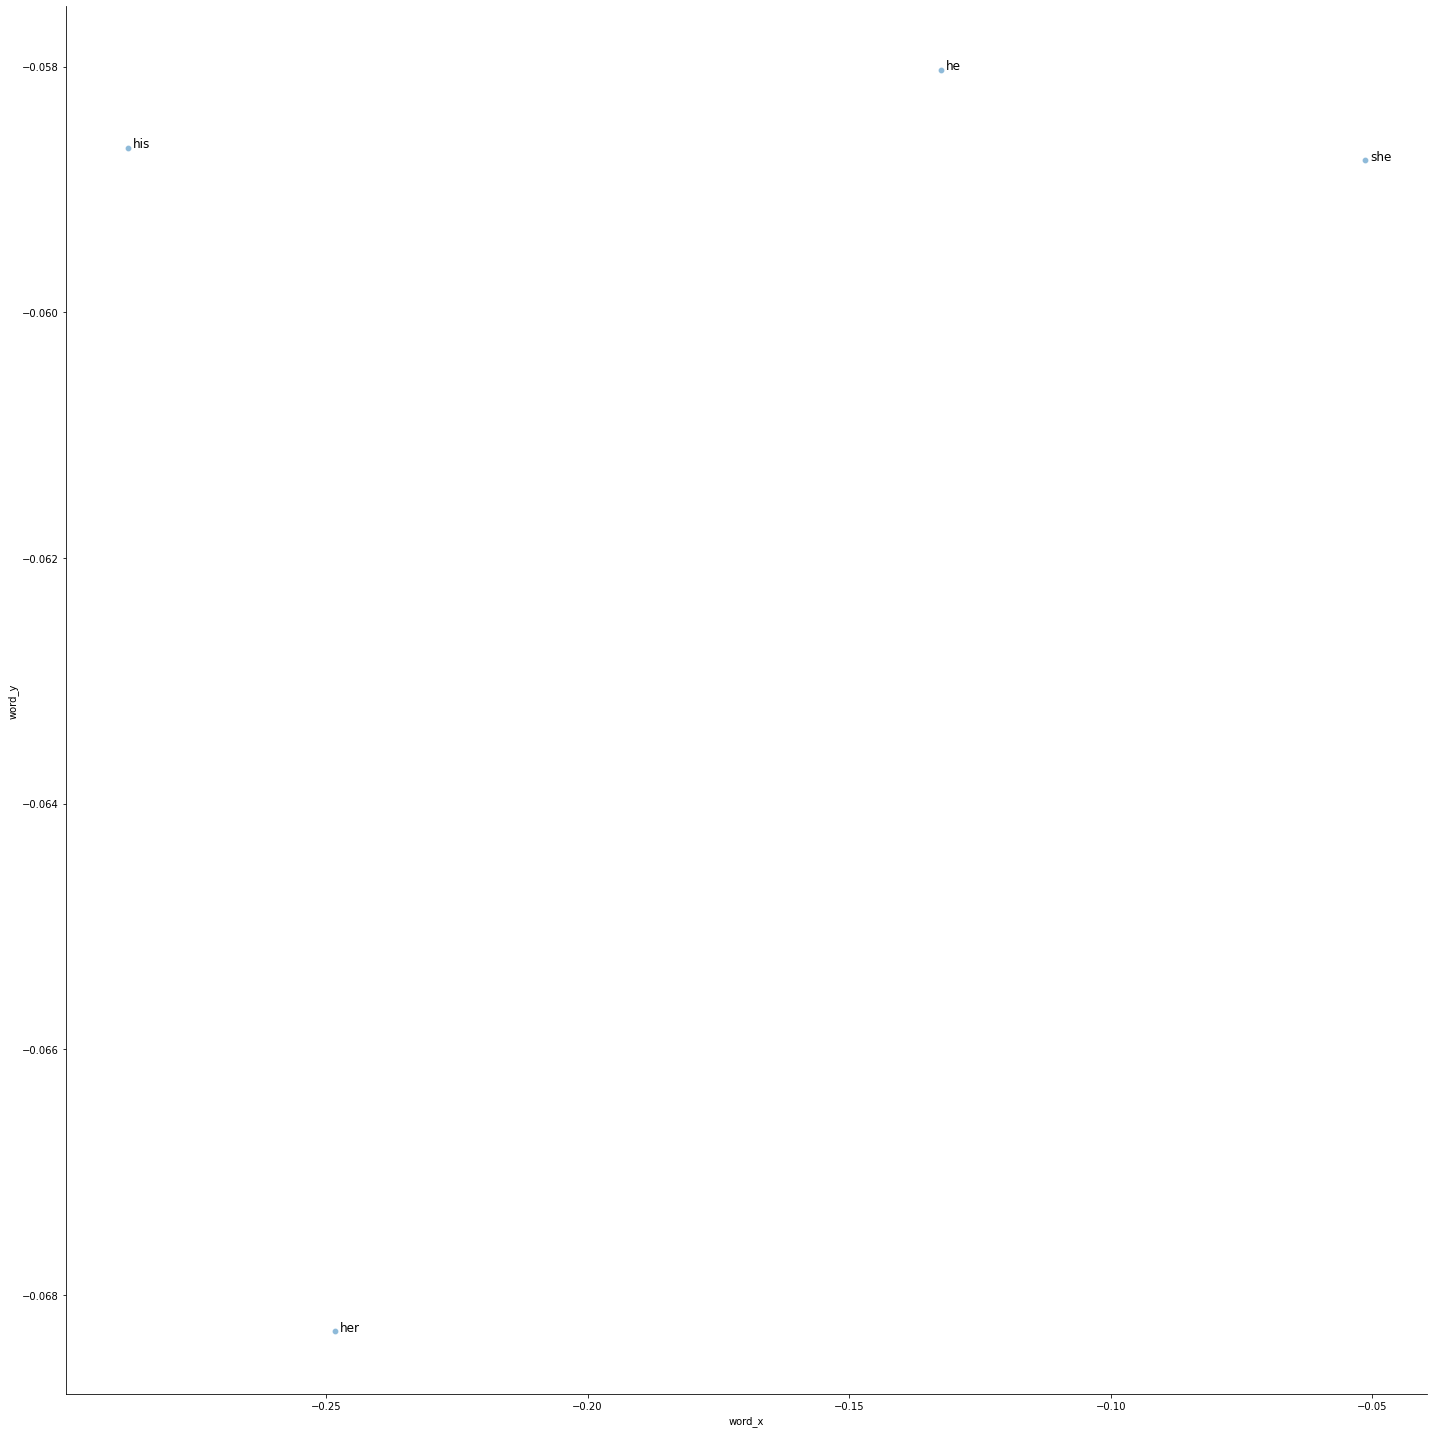

In [ ]:
# plot
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 40)

p = sns.relplot(x="word_x", y="word_y",
             alpha=.5, palette="muted", sizes=(70,450),
            height=20, aspect=1, data=df3)
ax = p.axes[0,0]

for idx, row in df3.iterrows():
     ax.text(row['word_x']+ 0.001, row['word_y'], row['word'], horizontalalignment='left', size='large', color='black')

In [ ]:
# # Using the embeddings, find the gender vector.
# gender_direction = find_gender_direction(df)
# print("gender direction: {}".format(str(gender_direction.flatten())))

In [ ]:
from itertools import chain

# she - he - positive cosine similarity shows greater similarity to women, negative cosine similarity (cosine dissimilarity) means skew towards men. 
gend_emb_list = df3.word_vec.tolist() 
gender1 = (gend_emb_list[0] - gend_emb_list[1]).tolist()
gender1 = list(chain.from_iterable(gender1))

gender2 = (gend_emb_list[2] - gend_emb_list[3]).tolist()
gender2 = list(chain.from_iterable(gender2))




m = [gender1, gender2]

m = np.array(m)
print(type(m))

<class 'numpy.ndarray'>


In [ ]:
def _np_normalize(v):
  """Returns the input vector, normalized."""
  return v / np.linalg.norm(v)

def find_gend_dir(m):
  m = np.cov(np.array(m).T)
  evals, evecs = np.linalg.eig(m)
  return _np_normalize(np.real(evecs[:, np.argmax(evals)])) 

In [ ]:
gend_dir = find_gend_dir(m)
print(len(gend_dir))

768


### **1.2.6 Computing Z (finding biased words)**

finding the gender direction of certain words. 

this is needed for computing Z from X. 

times the embedding vector for the word with the gender direction (the dot product) 

this finds the projection of words onto the gender dimension. 

"Once you have the first principal component of the embedding differences, you can start projecting the embeddings of words onto it.  That projection is roughly the degree to which a word is relevant to the latent protected variable defined by the first principle component of the word pairs given.  This projection can then be taken as the protected variable $Z$ which the adversary is attempting to predict on the basis of the predicted value of $Y$.  The code below illustrates how to construct a function which computes $Z$ from $X$ in this way." (Zhang et al., 2018). 

In [ ]:
# creating a dataframe of the word and the gender score 

word_count['gender_score'] = word_count['word_vec'].apply(lambda x: x.dot(gend_dir))
word_count.sort_values(by="gender_score", inplace=True, ascending=False)

word_count = word_count.drop_duplicates(subset='word_xy', keep="first")
word_count.head(50)

,,word,word_id,word_vec,word_xy,word_x,word_y,gender_score
279,13,him,1140,"[[-0.0072614825, 0.0067927386, -0.05...","(-0.12306432, -0.040898263)",-0.123064,-0.040898,[0.4098576350193786]
209,13,them,1172,"[[-0.039768152, 0.038077146, -0.0681...","(-0.13080277, 0.011410856)",-0.130803,0.011411,[0.301555928851446]
5,4,you,1128,"[[0.03152929, -0.026633339, -0.00208...","(-0.072345346, -0.039392192)",-0.072345,-0.039392,[0.2479957505533672]
78,11,her,1123,"[[0.004219352, 0.029523268, -0.04063...","(-0.24836737, -0.068293445)",-0.248367,-0.068293,[0.22702198833794549]
166,11,everyone,2490,"[[-0.066528976, -0.030940184, -0.041...","(0.19983438, -0.08325915)",0.199834,-0.083259,[0.1926036996712361]
172,9,it,1122,"[[-0.05863094, 0.020841248, -0.05307...","(-0.24472402, 0.0087961415)",-0.244724,0.008796,[0.1914588163321728]
323,9,someone,1800,"[[-0.05192881, 0.0013813454, -0.0132...","(0.18405202, -0.056739677)",0.184052,-0.056740,[0.17362321421189275]
143,14,people,1234,"[[0.023102827, -0.054270793, 0.04257...","(0.015495453, -0.0149338925)",0.015495,-0.014934,[0.17111710903685884]
251,14,himself,1471,"[[0.05603075, 0.06521894, -0.0052915...","(0.045876227, -0.003810009)",0.045876,-0.003810,[0.16891420066629204]
139,14,again,1254,"[[0.017396031, 0.0003180116, -0.0210...","(-0.07140406, -0.035140228)",-0.071404,-0.035140,[0.15937288270180985]


In [ ]:
def get_gendered_words(amount_of_ends, df):

    male_bias = df.iloc[-amount_of_ends:, :]
    female_bias = df.iloc[:amount_of_ends, :]

    male_biased = male_bias.word.tolist() 

    female_biased = female_bias.word.tolist()

    return male_biased, female_biased

In [ ]:
female_biased, male_biased = get_gendered_words(200, word_count)

In [ ]:
male_biased

In [ ]:
# just he-she - just the gender vector 
print(gender1)

[-0.033676836639642715, -0.005231767892837524, 0.011700871400535107, -0.0029432345181703568, -0.013645848259329796, 0.001717112958431244, 0.01881159096956253, 0.022894222289323807, 0.000630602240562439, -0.002193465828895569, 0.02447761967778206, 0.028327304869890213, -0.04307803884148598, 0.020644158124923706, 0.014895331114530563, 0.01500256359577179, -0.0006055673584342003, 0.027732431888580322, -0.013493400067090988, 0.011724410578608513, -0.0123604666441679, -0.0016453191637992859, 0.03541985899209976, 0.016428958624601364, -0.00718183908611536, -0.0023159440606832504, 0.005099721252918243, 0.03374837711453438, -0.026261163875460625, 0.018448373302817345, 0.008962143212556839, -6.936490535736084e-05, -0.02788468822836876, 0.004494909197092056, 0.012621345929801464, 0.02314835600554943, -0.0800473541021347, 0.003941982984542847, 0.015653003007173538, -0.027928035706281662, 0.006654469296336174, 0.0036245249211788177, 0.06488095968961716, 0.028497353196144104, -0.025919636711478233,

In [ ]:
word_count['gender_vector_score'] = word_count['word_vec'].apply(lambda x: x.dot(gender1))
word_count.sort_values(by="gender_vector_score", inplace=True, ascending=False)

word_count = word_count.drop_duplicates(subset='word_xy', keep="first")
 
word_count

,,word,word_id,word_vec,word_xy,word_x,word_y,gender_score,gender__vector_score,gender_vector_score,gender1
239,10,she,1131,"[[-0.03390125, 0.019389033, 0.001012...","(-0.051475607, -0.05875791)",-0.051476,-0.058758,[-0.04678698498798757],[0.26725218293141856],[0.26725218293141856],"[[-0.033676836639642715, -0.00523176..."
251,14,herself,1941,"[[-0.07277706, 0.038535852, 0.060213...","(0.19559273, -0.045169793)",0.195593,-0.045170,[0.03766322356153333],[0.24130878958510033],[0.24130878958510033],"[[-0.033676836639642715, -0.00523176..."
78,11,her,1123,"[[0.004219352, 0.029523268, -0.04063...","(-0.24836737, -0.068293445)",-0.248367,-0.068293,[0.22702198833794549],[0.21983656871879015],[0.21983656871879015],"[[-0.033676836639642715, -0.00523176..."
204,12,salon,20310,"[[-0.0529967, 0.0055915015, 0.009137...","(0.52415204, -0.14186354)",0.524152,-0.141864,[-0.1282347732269773],[0.1782143582182992],[0.1782143582182992],"[[-0.033676836639642715, -0.00523176..."
22,1,nurse,7439,"[[-0.043522343, -0.07187326, -0.0222...","(0.50982094, -0.11020863)",0.509821,-0.110209,[-0.0539946007855687],[0.16802116846817033],[0.16802116846817033],"[[-0.033676836639642715, -0.00523176..."
...,...,...,...,...,...,...,...,...,...,...,...
156,14,man,1299,"[[0.03547242, -0.009771521, 0.023980...","(0.045736633, -0.06240565)",0.045737,-0.062406,[0.13210394675078796],[-0.1579046540051693],[-0.1579046540051693],"[[-0.033676836639642715, -0.00523176..."
251,14,himself,1471,"[[0.05603075, 0.06521894, -0.0052915...","(0.045876227, -0.003810009)",0.045876,-0.003810,[0.16891420066629204],[-0.16773486082465344],[-0.16773486082465344],"[[-0.033676836639642715, -0.00523176..."
279,13,him,1140,"[[-0.0072614825, 0.0067927386, -0.05...","(-0.12306432, -0.040898263)",-0.123064,-0.040898,[0.4098576350193786],[-0.21684156215143174],[-0.21684156215143174],"[[-0.033676836639642715, -0.00523176..."
92,6,his,1117,"[[0.019576656, 0.037966713, -0.03355...","(-0.28787345, -0.05865933)",-0.287873,-0.058659,[-0.16719597499223526],[-0.218875252536186],[-0.218875252536186],"[[-0.033676836639642715, -0.00523176..."


In [ ]:
# converting from array to list 
gender_vector_score = word_count.gender_vector_score.tolist()

In [ ]:
gvs = []
for a in gender_vector_score:
  b = a.tolist()
  gvs.append(b)

In [ ]:
from itertools import chain
gvs = list(chain.from_iterable(gvs))

In [ ]:
word_count['gvs'] = gvs

In [ ]:
word_count['word'] = word_count['word'].apply(str)

In [ ]:
male_bias = word_count.iloc[1481:1501]
female_bias = word_count.iloc[:20]

In [ ]:
male_bias['gender'] = 'male'
female_bias['gender'] = 'female'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
frames = [male_bias, female_bias]
most_biased = pd.concat(frames)
most_biased.tail()

,,word,word_id,word_vec,word_xy,word_x,word_y,gender_score,gender__vector_score,gender_vector_score,gender1,gvs,gender
235,11,baking,26377,"[[-0.0470303, -0.08690991, 0.0192995...","(0.5597246, -0.075205915)",0.559725,-0.075206,[-0.07761073837367771],[0.11791155349537663],[0.11791155349537663],"[[-0.033676836639642715, -0.00523176...",0.117912,female
335,8,mall,8796,"[[0.004461368, -0.036715135, -0.0083...","(0.40021887, -0.09550279)",0.400219,-0.095503,[-0.10360401222753055],[0.11484094440634282],[0.11484094440634282],"[[-0.033676836639642715, -0.00523176...",0.114841,female
145,4,cookies,18621,"[[-0.00010624061, -0.017023064, 0.04...","(0.60200644, -0.051571205)",0.602006,-0.051571,[-0.07631581283718034],[0.11454639384970983],[0.11454639384970983],"[[-0.033676836639642715, -0.00523176...",0.114546,female
394,6,chatting,25132,"[[-0.034867432, -0.085606456, 0.0107...","(0.5945944, -0.12129597)",0.594594,-0.121296,[-0.05703643555026683],[0.10793631810783885],[0.10793631810783885],"[[-0.033676836639642715, -0.00523176...",0.107936,female
179,9,nails,10821,"[[-0.051925797, -0.012419899, -0.002...","(0.46631578, -0.086675465)",0.466316,-0.086675,[-0.09113436754362492],[0.09978475459449822],[0.09978475459449822],"[[-0.033676836639642715, -0.00523176...",0.099785,female


# **Plot**

## **1. Distribution of all of the words**

In [ ]:
word_count['colors'] = ['orange' if
        x > 0 else 'green' for x in word_count['gvs']]
  
# Sort values from lowest to highest
word_count.sort_values('gvs', inplace=True)

word_count.tail()

,,word,word_id,word_vec,word_xy,word_x,word_y,gender_score,gender__vector_score,gender_vector_score,gender1,gvs,colors
22,1,nurse,7439,"[[-0.043522343, -0.07187326, -0.0222...","(0.50982094, -0.11020863)",0.509821,-0.110209,[-0.0539946007855687],[0.16802116846817033],[0.16802116846817033],"[[-0.033676836639642715, -0.00523176...",0.168021,orange
204,12,salon,20310,"[[-0.0529967, 0.0055915015, 0.009137...","(0.52415204, -0.14186354)",0.524152,-0.141864,[-0.1282347732269773],[0.1782143582182992],[0.1782143582182992],"[[-0.033676836639642715, -0.00523176...",0.178214,orange
78,11,her,1123,"[[0.004219352, 0.029523268, -0.04063...","(-0.24836737, -0.068293445)",-0.248367,-0.068293,[0.22702198833794549],[0.21983656871879015],[0.21983656871879015],"[[-0.033676836639642715, -0.00523176...",0.219837,orange
251,14,herself,1941,"[[-0.07277706, 0.038535852, 0.060213...","(0.19559273, -0.045169793)",0.195593,-0.045170,[0.03766322356153333],[0.24130878958510033],[0.24130878958510033],"[[-0.033676836639642715, -0.00523176...",0.241309,orange
239,10,she,1131,"[[-0.03390125, 0.019389033, 0.001012...","(-0.051475607, -0.05875791)",-0.051476,-0.058758,[-0.04678698498798757],[0.26725218293141856],[0.26725218293141856],"[[-0.033676836639642715, -0.00523176...",0.267252,orange


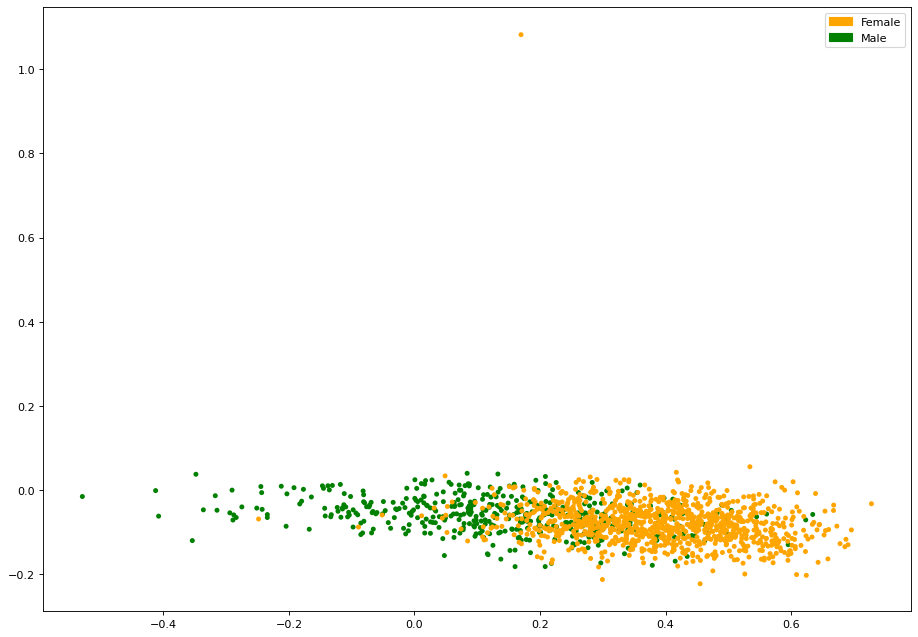

In [ ]:
import matplotlib.patches as mpatches
# Draw plot
plt.figure(figsize=(14, 10), dpi=80)
#fig, ax = plt.subplots()
plt.scatter(word_count['word_x'], 
            word_count['word_y'], 
            s = 20, 
            c=word_count['colors'],
            alpha=1, 
            edgecolors='none')
orange_patch = mpatches.Patch(color='orange', label='Female')
green_patch = mpatches.Patch(color='green', label='Male')
plt.legend(handles=[orange_patch, green_patch], loc = 'best')
plt.show()

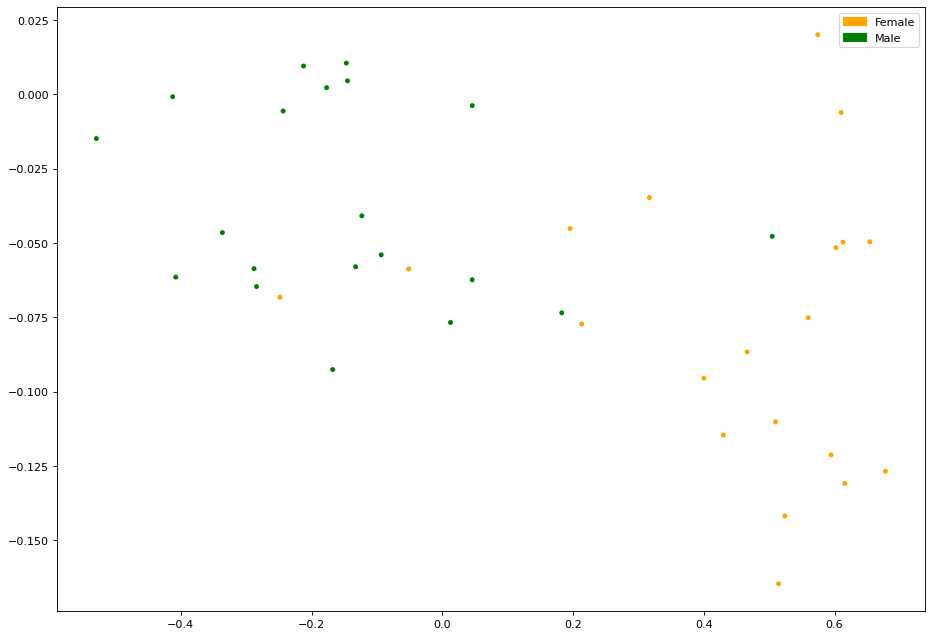

In [ ]:
# SAME BUT FOR MOST BIASED
# Draw plot
plt.figure(figsize=(14, 10), dpi=80)
#fig, ax = plt.subplots()
plt.scatter(most_biased['word_x'], 
            most_biased['word_y'], 
            s = 20, 
            c=most_biased['colors'],
            alpha=1, 
            edgecolors='none')
orange_patch = mpatches.Patch(color='orange', label='Female')
green_patch = mpatches.Patch(color='green', label='Male')
plt.legend(handles=[orange_patch, green_patch], loc = 'best')
plt.show()

## **2. Most Biased Words for male and female**

In [ ]:
# setting colours

most_biased['colors'] = ['orange' if x == 'female' else 'green' for x in most_biased['gender']]

In [ ]:
#sort values
most_biased.sort_values('gvs', inplace=True)
#df.reset_index(inplace=True)

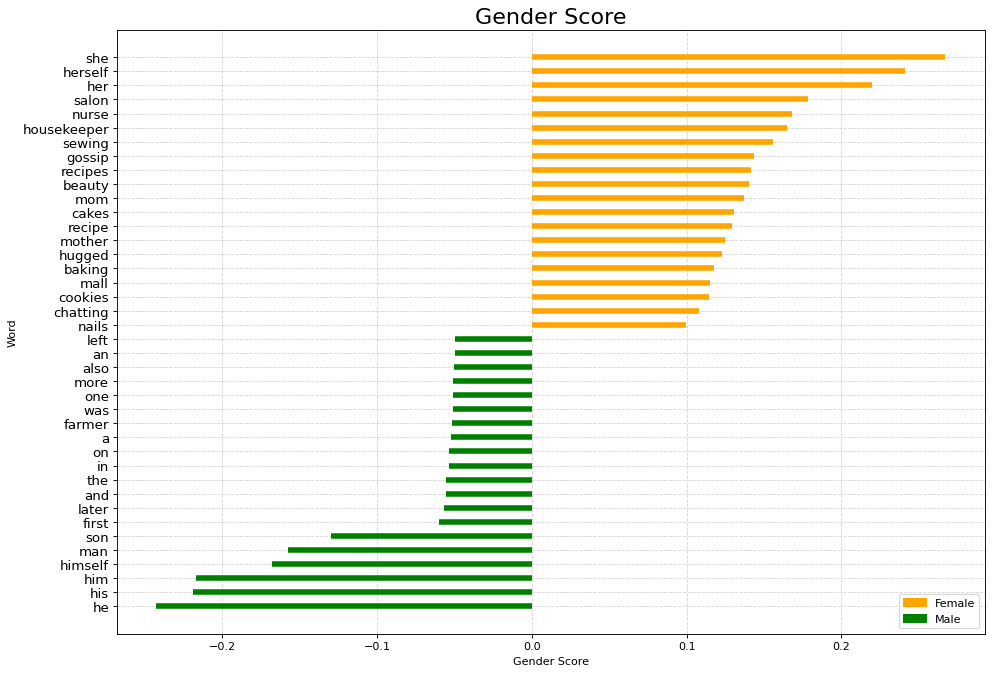

In [ ]:
# Draw plot
plt.figure(figsize=(14, 10), dpi=80)
  
# Plotting the horizontal lines
plt.hlines(y=most_biased.word, xmin=0, xmax=most_biased.gvs,
           color=most_biased.colors, alpha=1, linewidth=5)
  
# Decorations
# Setting the labels of x-axis and y-axis
plt.gca().set(ylabel='Word', xlabel='Gender Score')
  
# Setting Date to y-axis
plt.yticks(most_biased.word, fontsize=12)
  
# Title of Bar Chart
plt.title('Gender Score', fontdict={
          'size': 20})
  
# Optional grid layout
plt.grid(linestyle='--', alpha=0.5)

orange_patch = mpatches.Patch(color='orange', label='Female')
green_patch = mpatches.Patch(color='green', label='Male')
plt.legend(handles=[orange_patch, green_patch], loc = 'lower right')
# Displaying the Diverging Bar Chart
plt.show()

# **GENDER BIAS IN OCCUPATION WORDS**

In [ ]:
# getting occupations 
!cp "/content/gdrive/MyDrive/Colab Notebooks/wino_csv/occupations.csv" "/content/occupations.csv"

In [ ]:
occupations = pd.read_csv('occupations.csv')
occupations.head()

,Occupations
0,Accountant
1,Accounts Assistant
2,Accounts Clerk
3,Accounts Manager
4,Accounts Staff


In [ ]:
occ_list = occupations.Occupations.tolist()
occ_list[:5]

['Accountant',
 'Accounts Assistant',
 'Accounts Clerk',
 'Accounts Manager',
 'Accounts Staff']

In [ ]:
occ_list = [x.lower() for x in occ_list]

In [ ]:
df_list2 = [] 
for o in occ_list:
    df5 = pd.DataFrame(word_count.loc[word_count['word'] == o])
    df_list2.append(df5)

df6 = pd.concat(df_list2, ignore_index = True)
#df6 = df6.drop_duplicates(subset='word', keep="first")
df6.sort_values(by="gender_vector_score", inplace=True, ascending=False)

In [ ]:
df6

,word,word_id,word_vec,word_xy,word_x,word_y,gender_score,gender__vector_score,gender_vector_score,gender1,gvs,colors
15,nurse,7439,"[[-0.043522343, -0.07187326, -0.0222...","(0.50982094, -0.11020863)",0.509821,-0.110209,[-0.0539946007855687],[0.16802116846817033],[0.16802116846817033],"[[-0.033676836639642715, -0.00523176...",0.168021,orange
11,housekeeper,26458,"[[0.017081143, -0.037035644, 0.03373...","(0.67791027, -0.12682642)",0.677910,-0.126826,[-0.07363718967864974],[0.16497899075348735],[0.16497899075348735],"[[-0.033676836639642715, -0.00523176...",0.164979,orange
13,librarian,18280,"[[0.02209205, -0.0816464, -0.0415484...","(0.69067955, -0.12939934)",0.690680,-0.129399,[-0.03613128418506155],[0.06574791260983764],[0.06574791260983764],"[[-0.033676836639642715, -0.00523176...",0.065748,orange
5,cleaner,23722,"[[-0.026834276, -0.12454485, 0.02742...","(0.56973755, -0.09179544)",0.569738,-0.091795,[-0.07370287590981811],[0.05785359222367853],[0.05785359222367853],"[[-0.033676836639642715, -0.00523176...",0.057854,orange
17,secretary,4848,"[[-0.071421206, -0.06413245, -0.0359...","(0.5544284, -0.110608496)",0.554428,-0.110608,[-0.09786214915769223],[0.053865404725063376],[0.053865404725063376],"[[-0.033676836639642715, -0.00523176...",0.053865,orange
3,attendant,19389,"[[-0.051711533, -0.014830579, 0.0016...","(0.5219708, -0.09409491)",0.521971,-0.094095,[-0.020562019843328054],[0.031611382807689756],[0.031611382807689756],"[[-0.033676836639642715, -0.00523176...",0.031611,orange
9,employee,7775,"[[-0.012865962, -0.030752758, -0.024...","(0.4554755, -0.16672945)",0.455476,-0.166729,[-0.06257019721618089],[0.02319693945390811],[0.02319693945390811],"[[-0.033676836639642715, -0.00523176...",0.023197,orange
8,editor,3045,"[[-0.06561848, -0.054955337, -0.0757...","(0.49304858, -0.092275)",0.493049,-0.092275,[-0.02923957610666096],[0.018956495047461344],[0.018956495047461344],"[[-0.033676836639642715, -0.00523176...",0.018956,orange
0,accountant,23195,"[[0.027775774, -0.065841354, -0.0395...","(0.62684304, -0.11609952)",0.626843,-0.116100,[-0.09808051707654253],[0.015240284816766536],[0.015240284816766536],"[[-0.033676836639642715, -0.00523176...",0.015240,orange
6,clerk,9477,"[[-0.021356523, -0.06134745, -0.0699...","(0.59739894, -0.14450541)",0.597399,-0.144505,[-0.025976411820684282],[0.013578556251048528],[0.013578556251048528],"[[-0.033676836639642715, -0.00523176...",0.013579,orange


In [ ]:
# getting occupation words out of the data 
occupations = ['attendant',
'cashier',
'teacher',
'nurse',
'assistant',
'secretary',
'auditor',
'cleaner',
'receptionist',
'clerk',
'counselor',
'designer',
'hairdresser',
'writer',
'housekeeper',
'baker',
'accountant',
'editor',
'librarian',
'tailor',
'driver',
'supervisor',
'janitor',
'cook',
'mover',
'laborer',
'construction worker', 
'chief',
'developer',
'carpenter',
'manager',
'lawyer',
'farmer',
'salesperson',
'physician',
'guard',
'analyst',
'mechanic',
'sheriff',
'CEO']


In [ ]:
df_list3 = [] 
for o in occupations:
    df7 = pd.DataFrame(word_count.loc[word_count['word'] == o])
    df_list3.append(df7)

df8 = pd.concat(df_list3, ignore_index = True)
df8 = df8.drop_duplicates(subset='word', keep="first")
df8.sort_values(by="gvs", inplace=True, ascending=False)

In [ ]:
df8

,word,word_id,word_vec,word_xy,word_x,word_y,gender_score,gender__vector_score,gender_vector_score,gender1,gvs,colors
2,nurse,7439,"[[-0.043522343, -0.07187326, -0.0222...","(0.50982094, -0.11020863)",0.509821,-0.110209,[-0.0539946007855687],[0.16802116846817033],[0.16802116846817033],"[[-0.033676836639642715, -0.00523176...",0.168021,orange
10,housekeeper,26458,"[[0.017081143, -0.037035644, 0.03373...","(0.67791027, -0.12682642)",0.677910,-0.126826,[-0.07363718967864974],[0.16497899075348735],[0.16497899075348735],"[[-0.033676836639642715, -0.00523176...",0.164979,orange
16,cook,9834,"[[-0.0135600725, -0.052522752, -0.02...","(0.5077577, -0.09599425)",0.507758,-0.095994,[-0.02857456400988334],[0.07766088726590478],[0.07766088726590478],"[[-0.033676836639642715, -0.00523176...",0.077661,orange
13,librarian,18280,"[[0.02209205, -0.0816464, -0.0415484...","(0.69067955, -0.12939934)",0.690680,-0.129399,[-0.03613128418506155],[0.06574791260983764],[0.06574791260983764],"[[-0.033676836639642715, -0.00523176...",0.065748,orange
8,designer,5592,"[[-0.090065554, -0.025961962, 0.0549...","(0.4875051, -0.11800066)",0.487505,-0.118001,[-0.09714058245609836],[0.061372851650850754],[0.061372851650850754],"[[-0.033676836639642715, -0.00523176...",0.061373,orange
5,cleaner,23722,"[[-0.026834276, -0.12454485, 0.02742...","(0.56973755, -0.09179544)",0.569738,-0.091795,[-0.07370287590981811],[0.05785359222367853],[0.05785359222367853],"[[-0.033676836639642715, -0.00523176...",0.057854,orange
7,counselor,23550,"[[-0.041580316, 0.04279565, -0.02057...","(0.6332605, -0.111048646)",0.633260,-0.111049,[-0.05610311756171045],[0.05493334952415206],[0.05493334952415206],"[[-0.033676836639642715, -0.00523176...",0.054933,orange
4,secretary,4848,"[[-0.071421206, -0.06413245, -0.0359...","(0.5544284, -0.110608496)",0.554428,-0.110608,[-0.09786214915769223],[0.053865404725063376],[0.053865404725063376],"[[-0.033676836639642715, -0.00523176...",0.053865,orange
0,attendant,19389,"[[-0.051711533, -0.014830579, 0.0016...","(0.5219708, -0.09409491)",0.521971,-0.094095,[-0.020562019843328054],[0.031611382807689756],[0.031611382807689756],"[[-0.033676836639642715, -0.00523176...",0.031611,orange
28,CEO,5058,"[[0.048467692, 0.0073128664, -0.0376...","(0.4895755, -0.033515427)",0.489576,-0.033515,[-0.09247871777061205],[0.02001133120374384],[0.02001133120374384],"[[-0.033676836639642715, -0.00523176...",0.020011,orange


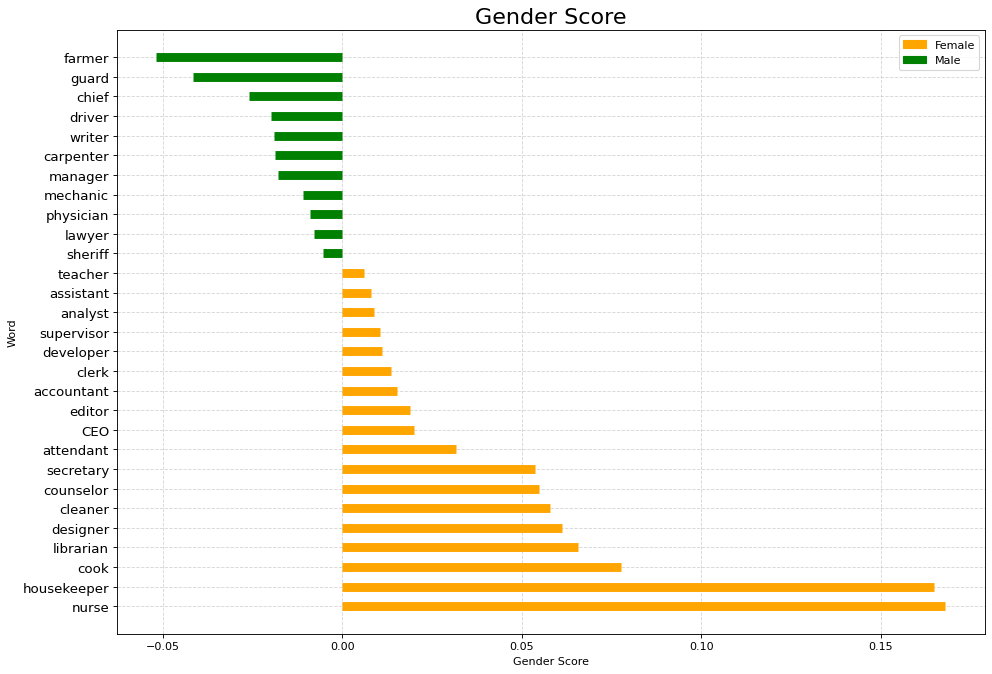

In [ ]:
# bar chart

# Draw plot
plt.figure(figsize=(14, 10), dpi=80)
  
# Plotting the horizontal lines
plt.hlines(y=df8.word, xmin=0, xmax=df8.gvs,
           color=df8.colors, alpha=1, linewidth=8)
  
# Decorations
# Setting the labels of x-axis and y-axis
plt.gca().set(ylabel='Word', xlabel='Gender Score')
  
# Setting Date to y-axis
plt.yticks(df8.word, fontsize=12)
  
# Title of Bar Chart
plt.title('Gender Score', fontdict={
          'size': 20})
  
# Optional grid layout
plt.grid(linestyle='--', alpha=0.5)

orange_patch = mpatches.Patch(color='orange', label='Female')
green_patch = mpatches.Patch(color='green', label='Male')
plt.legend(handles=[orange_patch, green_patch], loc = 'upper right')
# Displaying the Diverging Bar Chart
plt.show()

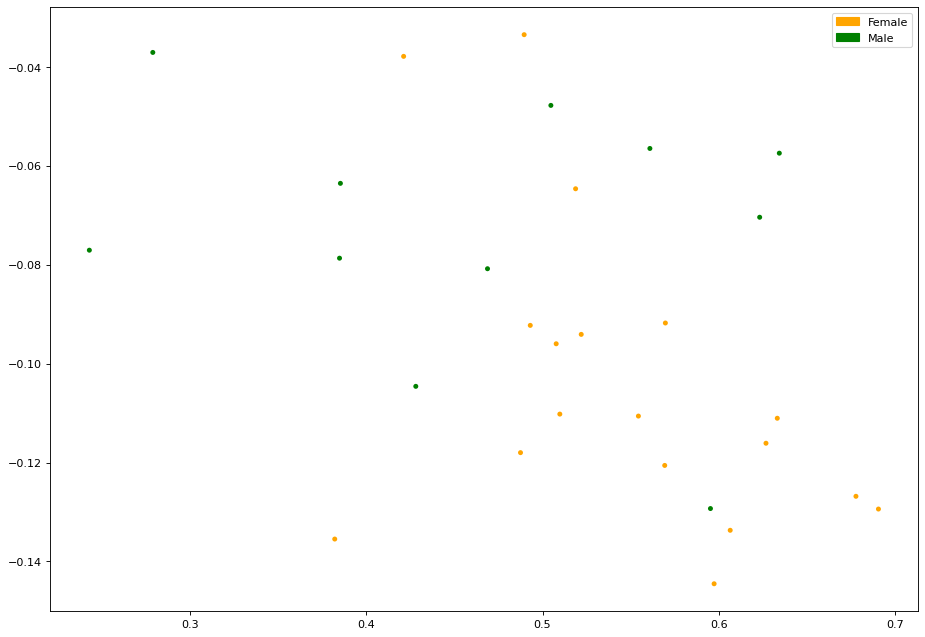

In [ ]:
import matplotlib.patches as mpatches
# Draw plot
plt.figure(figsize=(14, 10), dpi=80)
#fig, ax = plt.subplots()
plt.scatter(df8['word_x'], 
            df8['word_y'], 
            s = 20, 
            c=df8['colors'],
            alpha=1, 
            edgecolors='none')
orange_patch = mpatches.Patch(color='orange', label='Female')
green_patch = mpatches.Patch(color='green', label='Male')
plt.legend(handles=[orange_patch, green_patch], loc = 'best')
plt.show()

## **CORRELATION WITH LABOUR MARKET STATISTICS**

In [ ]:
# read in data from Garg 

import pandas as pd

occ_perc = pd.read_csv (r'occupation_percentages_fromGARG.txt')
occ_perc.to_csv (r'occ_perc.csv', index=None)

In [ ]:
occ_perc

,Census year,Occupation,Total Weight,Female,Male
0,2007,judge,1128029.0,0.337325,0.662675
1,1990,bookbinder,37767.0,0.559192,0.440808
2,1960,salesperson,402520.0,0.367684,0.632316
3,2000,broker,2202877.0,0.568766,0.431234
4,2007,dancer,27296.0,0.792424,0.207576
...,...,...,...,...,...
3275,2011,machinist,433226.0,0.051147,0.948853
3276,2015,welder,761642.0,0.052389,0.947611
3277,2014,janitor,5889048.0,0.536221,0.463779
3278,1940,plasterer,59828.0,0.015043,0.984957


In [ ]:
occ_perc_merge = df8.merge(occ_perc, left_on='word', right_on='Occupation', how='left')
occ_perc_merge = occ_perc_merge.drop_duplicates(subset='word', keep="first")
occ_perc_merge.head()

,word,word_id,word_vec,word_xy,word_x,word_y,gender_score,gender__vector_score,gender_vector_score,gender1,gvs,colors,Census year,Occupation,Total Weight,Female,Male
0,nurse,7439,"[[-0.043522343, -0.07187326, -0.0222...","(0.50982094, -0.11020863)",0.509821,-0.110209,[-0.0539946007855687],[0.16802116846817033],[0.16802116846817033],"[[-0.033676836639642715, -0.00523176...",0.168021,orange,1900.0,nurse,115193.26,0.936499,0.063501
30,housekeeper,26458,"[[0.017081143, -0.037035644, 0.03373...","(0.67791027, -0.12682642)",0.677910,-0.126826,[-0.07363718967864974],[0.16497899075348735],[0.16497899075348735],"[[-0.033676836639642715, -0.00523176...",0.164979,orange,2008.0,housekeeper,156346.00,0.791507,0.208493
60,cook,9834,"[[-0.0135600725, -0.052522752, -0.02...","(0.5077577, -0.09599425)",0.507758,-0.095994,[-0.02857456400988334],[0.07766088726590478],[0.07766088726590478],"[[-0.033676836639642715, -0.00523176...",0.077661,orange,2009.0,cook,5365084.00,0.496321,0.503679
90,librarian,18280,"[[0.02209205, -0.0816464, -0.0415484...","(0.69067955, -0.12939934)",0.690680,-0.129399,[-0.03613128418506155],[0.06574791260983764],[0.06574791260983764],"[[-0.033676836639642715, -0.00523176...",0.065748,orange,2006.0,librarian,2342933.00,0.874226,0.125774
120,designer,5592,"[[-0.090065554, -0.025961962, 0.0549...","(0.4875051, -0.11800066)",0.487505,-0.118001,[-0.09714058245609836],[0.061372851650850754],[0.061372851650850754],"[[-0.033676836639642715, -0.00523176...",0.061373,orange,2005.0,designer,957604.00,0.585572,0.414428


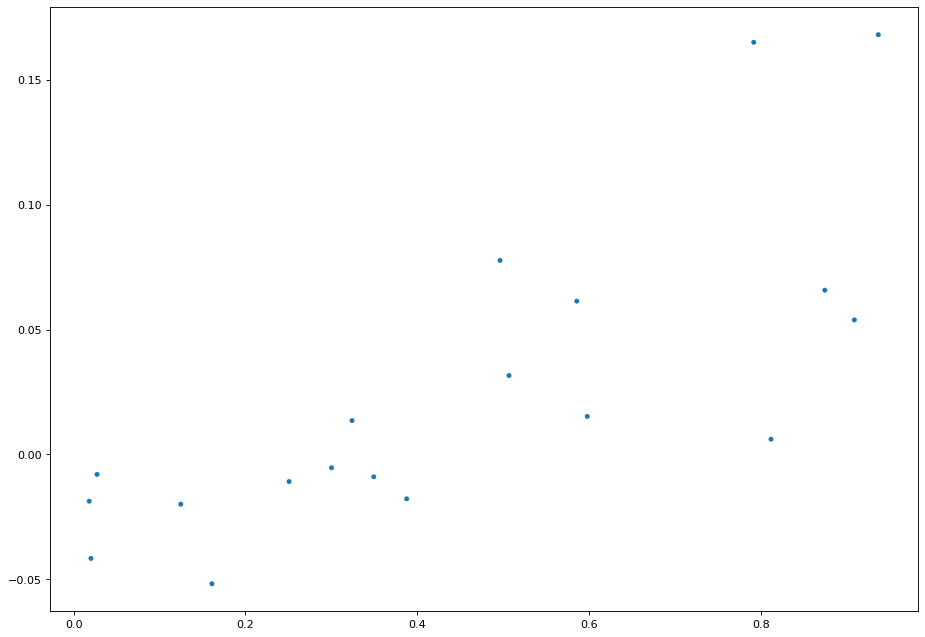

ValueError: ignored

In [ ]:
# SAME BUT FOR MOST BIASED
# Draw plot
plt.figure(figsize=(14, 10), dpi=80)
#fig, ax = plt.subplots()
plt.scatter(occ_perc_merge['Female'], 
            occ_perc_merge['gvs'], 
            s = 20,
            alpha=1, 
            edgecolors='none')
# orange_patch = mpatches.Patch(color='orange', label='Female')
# green_patch = mpatches.Patch(color='green', label='Male')
# plt.legend(handles=[orange_patch, green_patch], loc = 'best')
plt.show()

m, b = np.polyfit(occ_perc_merge['Female'], occ_perc_merge['gvs'], 1)

#add linear regression line to scatterplot 
plt.plot(x, m*x+b)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


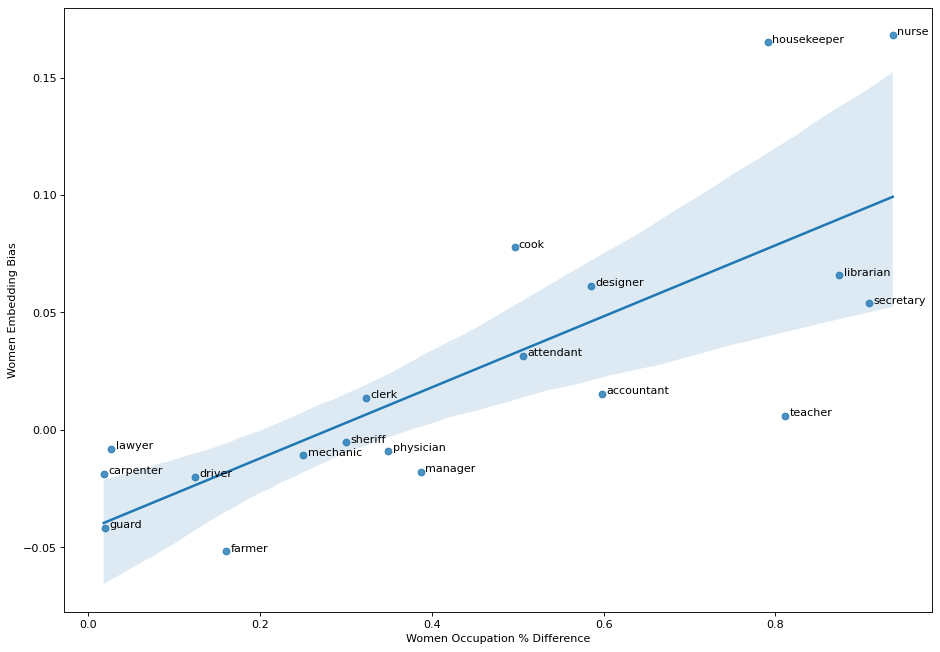

In [ ]:
plt.figure(figsize=(14, 10), dpi=80)
ax = sns.regplot(x='Female', 
            y="gvs", 
            data=occ_perc_merge);

ax.set(xlabel='Women Occupation % Difference', ylabel='Women Embedding Bias')


def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.005, point['y'], str(point['val']))

label_point(occ_perc_merge.Female, occ_perc_merge.gvs, occ_perc_merge.word, ax) 
plt.show()



In [ ]:
# CALCULATING THE REGRESSION 

import numpy as np
from sklearn.linear_model import LinearRegression

In [ ]:
# remove NA data from dataframe 
occ_perc_merge = occ_perc_merge.dropna()

In [ ]:
x = occ_perc_merge.Female.values.reshape(-1, 1)
y = occ_perc_merge.gvs.values.reshape(-1, 1)

In [ ]:
model = LinearRegression()
model.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.5907619741335379


In [ ]:
print('intercept:', model.intercept_)
print('slope:', model.coef_)

intercept: [-0.04240603]
slope: [[0.1512285]]


In [ ]:
import statsmodels.api as sm
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     24.54
Date:                Sat, 09 Oct 2021   Prob (F-statistic):           0.000121
Time:                        18:46:57   Log-Likelihood:                 35.070
No. Observations:                  19   AIC:                            -66.14
Df Residuals:                      17   BIC:                            -64.25
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0424      0.016     -2.575      0.0

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


In [ ]:
import statsmodels.api as sm
mod = sm.OLS(y,x)
fii = mod.fit()
p_values = fii.summary2().tables[1]['P>|t|']
p_values

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


x1    0.00036
Name: P>|t|, dtype: float64